In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import cv2

from keras.models import Model, Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from keras.layers.normalization import batch_normalization
import os
import seaborn as sns

2023-04-07 22:31:27.102101: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Set up folder
SIZE = 256 #Size of the images this model will deal with
IMDIM = 1

In [3]:
# Set up folder, unless it is already set up
p = os.path.abspath('.')
resized_dir = os.path.join(p, f'{SIZE}')
if not os.path.exists(resized_dir):
    os.mkdir(resized_dir)
    print(f"{resized_dir} created")
else:
    print(f"{resized_dir} already exists")

# Resize images and write them into folder, unless they are alrady there
for file in glob.glob('./Thresholded/*'):
	filename = file.split('/')[-1]
	new_name = os.path.join(resized_dir, filename)
	if not os.path.exists(new_name):
		img = cv2.imread(file, cv2.IMREAD_COLOR)
		img = cv2.resize(img, (SIZE,SIZE))
		cv2.imwrite(new_name, img)

# Read filenames in the folder
image_names = []
labels = []

for file in glob.glob(f'{resized_dir}/*.jpg'):
	filename = file.split('/')[-1]
	num_colonies = int(filename.split('-')[2].strip().split('.')[0])
	if num_colonies == 0:
		labels.append(0)
	else:
		labels.append(1)
	image_names.append(filename)

image_names = np.array(image_names) #  Array with image nbames
labels = np.array(labels)			#  Array with binary labels

#  Make two arrays with filenames: one for positive and one for negative images
pos_im_files = [image_names[i] for i in range(image_names.shape[0]) if labels[i]]
pos_im_files = np.array(pos_im_files)
neg_im_files = [image_names[i] for i in range(image_names.shape[0]) if not labels[i]]
neg_im_files = np.array(neg_im_files)
num_pos = pos_im_files.shape[0]
num_neg = neg_im_files.shape[0]
print(f'Full dataset: {num_pos} images with bacteria and {num_neg} without')

#  There are ~10x positive than negative.
#  For initital training let's get all positive and equal number of negative
#  For that:
#  (1) Index files of randomly selected negative images
np.random.seed(0) # For reproducibility
idx = np.random.choice(np.arange(neg_im_files.shape[0]), 2*num_pos, replace = False)
#  (2) Apply this index to the array of image names
neg_selected_files = neg_im_files[idx]
print(f"{pos_im_files.shape[0]}pos selected and {neg_selected_files.shape[0]} negative selected")

/home/art_usr/source_code/CFU_counter/256 already exists
Full dataset: 315 images with bacteria and 3428 without
315pos selected and 630 negative selected


In [4]:
# Read the positive files, only red channel
# Also add flipped image
print("Reading positive images...")
images = []
new_labels = []
for file_name in pos_im_files:
    file = os.path.join(resized_dir, file_name)
    img = cv2.imread(file, cv2.IMREAD_COLOR)
    images.append(img/255) # Scale all images
    new_labels.append(1)
    img_flip_vert = cv2.flip(img,0)
    images.append(img_flip_vert/255) # Scale all images
    new_labels.append(1)

print("Reading negative images...")
for file_name in neg_selected_files:
    file = os.path.join(resized_dir, file_name)
    img = cv2.imread(file, cv2.IMREAD_COLOR)
    images.append(img/255) # Scale all images
    new_labels.append(0)

images = np.array(images)
new_labels = np.array(new_labels)

# Now shuffle the images and labels
print("Shuffling the dataset ....")
num_datapoints = images.shape[0]
indices = np.arange(num_datapoints)
shuffled_indices = np.random.permutation(indices)
X_shuffled = images[shuffled_indices]
y_shuffled = new_labels[shuffled_indices]

print(f'Set shape: X-> {X_shuffled.shape}, y->{y_shuffled.shape}')

Reading positive images...
Reading negative images...
Shuffling the dataset ....
Set shape: X-> (1260, 256, 256, 3), y->(1260,)


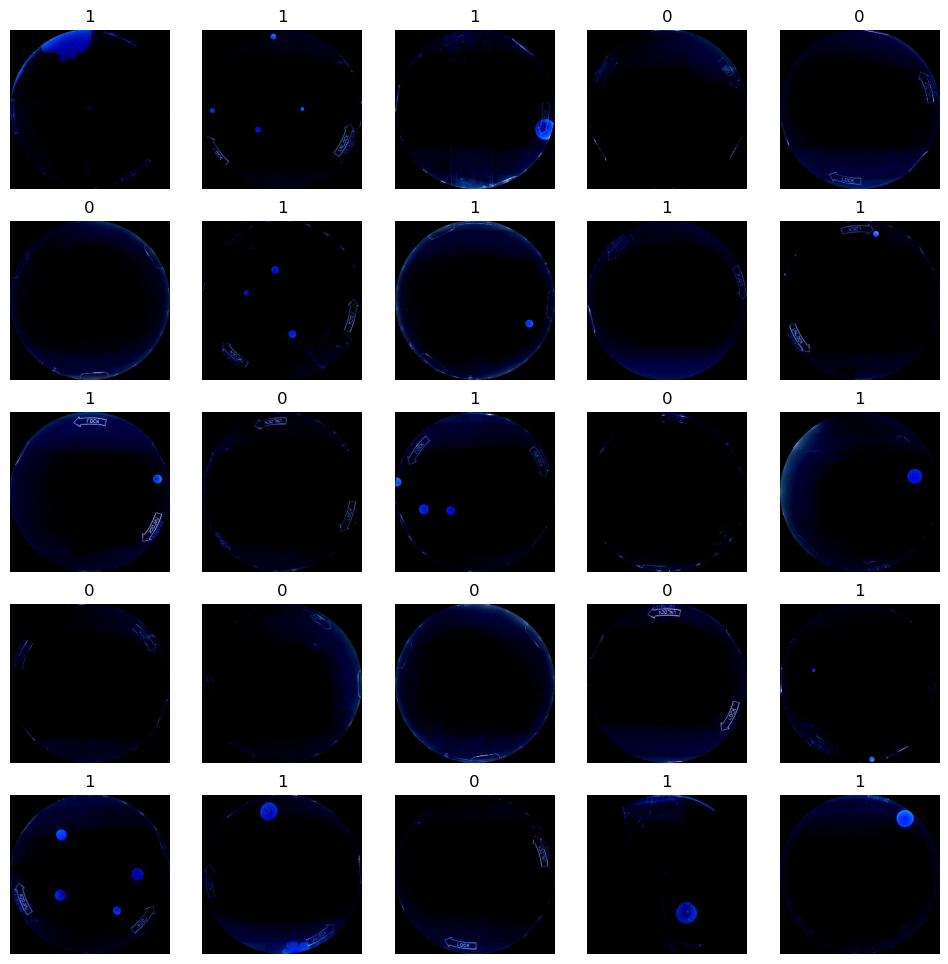

In [5]:
# Visualize first 25 images to make sure it makes sense
fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(12,12))

for i, j in [(i,j) for i in np.arange(5) for j in np.arange(5)]:
    idx = 5*i+j
    image = X_shuffled[idx]
    axs[i,j].imshow(image)
    axs[i,j].set_title(y_shuffled[idx])
    axs[i,j].axis('off')

plt.show()

In [6]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.callbacks import Callback
from sklearn.metrics import f1_score, accuracy_score
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D

# Define the image size and input_shape
img_size = (SIZE, SIZE)
input_shape = (*img_size, 3)

# Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_shuffled, y_shuffled, test_size=0.3, random_state=42)

# One-hot encode the labels
num_classes = max(labels) + 1
y_train = to_categorical(y_train, num_classes=num_classes)
y_val = to_categorical(y_val, num_classes=num_classes)

# Create a TensorFlow Dataset
train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(32).prefetch(tf.data.AUTOTUNE)
val_data = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(32).prefetch(tf.data.AUTOTUNE)

# Define the EfficientNet model
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Flatten()
])

# Freeze the base model's layers for fine-tuning
for layer in base_model.layers:
    layer.trainable = False

2023-04-07 22:31:41.951113: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-07 22:31:41.952422: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [7]:
#Now, let us use features from convolutional network for RF
X_for_RF = model.predict(X_train) #This is out X input to RF

#RANDOM FOREST
from sklearn.ensemble import RandomForestClassifier
RF_model = RandomForestClassifier(n_estimators = 50, random_state = 42)

y_train_dense = tf.argmax(y_train, axis=1)
y_test_dense = tf.argmax(y_val, axis=1)
# Train the model on training data
RF_model.fit(X_for_RF, y_train_dense) #For sklearn no one hot encoding

#Send test data through same feature extractor process
X_test_feature = model.predict(X_val)
#Now predict using the trained RF model. 
prediction_RF = RF_model.predict(X_test_feature)

#Print overall accuracy
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(y_test_dense, prediction_RF))

12/12 [==============================] - 33s 3s/step
Accuracy =  0.8068783068783069


<AxesSubplot: >

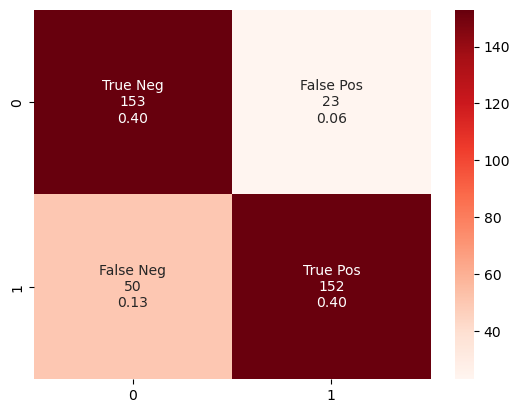

In [8]:
#Confusion Matrix - verify accuracy of each class
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test_dense, prediction_RF)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = [f'{value}' for value in cm.flatten()]
group_percentages = [f'{value:.2f}' for value in cm.flatten()/np.sum(cm)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cm, annot=labels, fmt='', cmap='Reds')

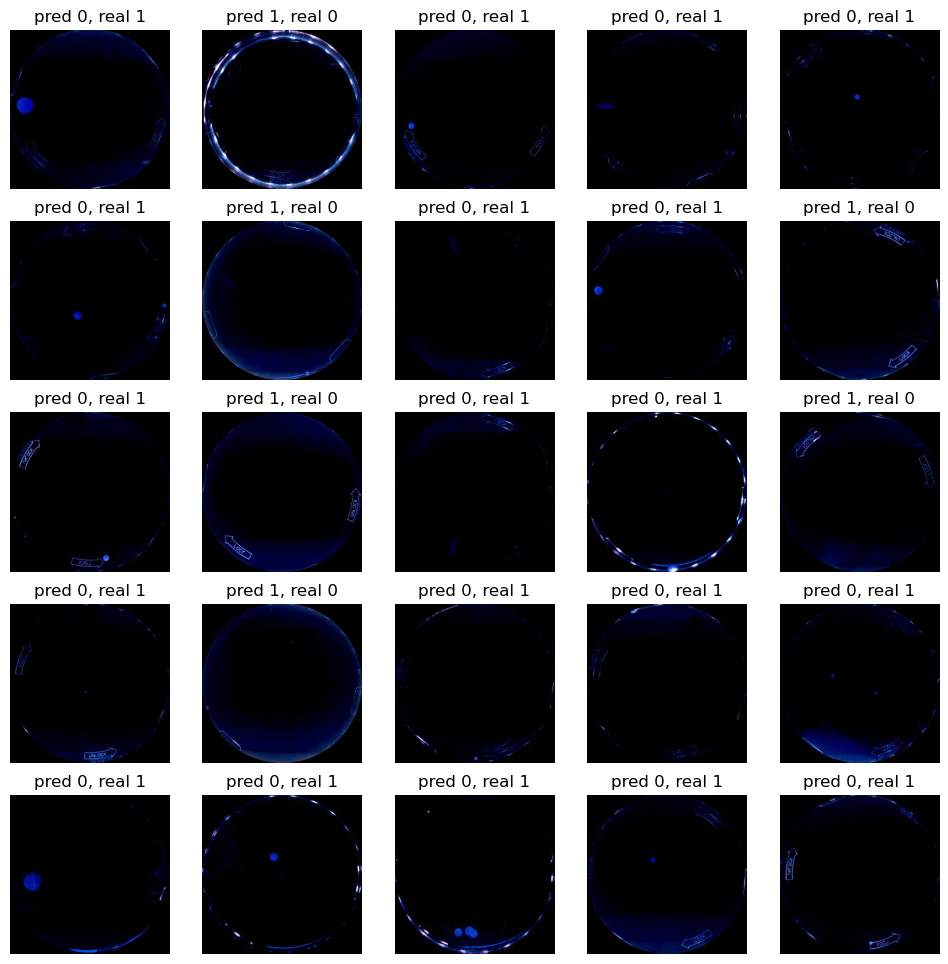

In [9]:
# Visualize 25 mistakes
error_idx = [i for i, rslt in enumerate(y_test_dense) if (rslt + prediction_RF[i] == 1)]

fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(12,12))

for i, j in [(i,j) for i in np.arange(5) for j in np.arange(5)]:
    if (5*i+j) < len(error_idx):
        idx = error_idx[5*i+j]
        axs[i,j].imshow(X_val[idx])
        axs[i,j].set_title(f'pred {int(prediction_RF[idx])}, real {int(y_test_dense[idx])}')
        axs[i,j].axis('off')

plt.show()